In [1]:
import numpy as np
#from time import time
import os
from PIL import Image
import random
import matplotlib.pyplot as plt

In [2]:
def relu(mat):
    return(np.multiply(mat,np.where(mat>=0,1,0)))

def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def sigmoid_backward(A):
    da = sigmoid(A)
    return da*(1-da)
def relu_backward(A):
    return np.where(A>=0,1,0)

In [20]:
def data(path):

    os.chdir(path)
    #os.chdir("cats")
    aa=["cats","dogs"]
    training_data=[]

    #print(X)
    for a in aa:
        path = os.path.join(os.getcwd(),a)
        ind = aa.index(a) 
        print(path)
        for img in os.listdir(path):
            try:

                image  = Image.open(os.path.join(path,img))
                image = image.convert("L")
                image =image.resize((80,80))
                
                image = np.array(image)
                training_data.append([image,ind])
            except IOError:
                pass
    
    random.shuffle(training_data)
    X=[]
    Y=[]
    for x,y in training_data:
        X.append(x)
        Y.append(y)
    X=np.array(X)
    Y = np.array(Y)
    
    #X=X.reshape(X.shape[1], X.shape[2],X.shape[0])
    
    Y=Y.reshape(Y.shape[0],1)
  

          
    return X,Y

In [27]:
#os.chdir("../../../")

print(os.getcwd())


X_train,Y_train = data("Desktop/cat-and-dog/training_set")
print(X_train.shape,Y_train.shape)
X_train=X_train/255
print("done")

C:\Users\LAPY
C:\Users\LAPY\Desktop\cat-and-dog\training_set\cats
C:\Users\LAPY\Desktop\cat-and-dog\training_set\dogs
(8005, 80, 80) (8005, 1)
done


In [29]:
#os.chdir("../../")

print(os.getcwd())


X_test,Y_test = data("cat-and-dog/test_set/test_set")
print(X_test.shape,Y_test.shape)
X_test=X_test/255

C:\Users\LAPY\Desktop
C:\Users\LAPY\Desktop\cat-and-dog\test_set\test_set\cats
C:\Users\LAPY\Desktop\cat-and-dog\test_set\test_set\dogs
(2023, 80, 80) (2023, 1)


In [30]:
def compute_cost(AL,Y):

    m =Y.shape[0]
    
    cost = np.sum(np.multiply(Y,np.log(AL)),axis=1,keepdims=True) + np.sum(np.multiply(1-Y,np.log(1-AL)),axis=1,keepdims=True)
   # print(cost.shape)
    cost=np.sum(cost)
    #print(cost)
    cost = cost/-m  
    
    cost = np.squeeze(cost) #(will turn [[13]] -> 13)
    
    assert(cost.shape == ())
    return cost

In [7]:
def d_conv(imag,filt,stride,pad):
    cnv_0 = imag.shape[0]
    cnv_1 = ((imag.shape[1] + 2*pad) - filt.shape[1])//stride + 1
    cnv_2 = ((imag.shape[2] + 2*pad) - filt.shape[2])//stride + 1
    
    b = np.zeros((filt.shape[1]*filt.shape[2],cnv_1*cnv_2*cnv_0),dtype="float64")
    print(b.shape,filt.shape)
    #return
    z=0
    for t in range(cnv_0):
        for i in range(cnv_1):
            v_start = i * stride
            v_end = v_start + filt.shape[1]
            for j in range(cnv_2):


                h_start = j * stride
                h_end = h_start + filt.shape[2]

                b[:,z] = imag[t,v_start:v_end,h_start:h_end].flatten()

                z+=1
    b=np.reshape(b,(b.shape[0],cnv_1*cnv_2*cnv_0))
    b=np.dot(np.reshape(filt,(filt.shape[0]*filt.shape[1]*filt.shape[2],1)).T,b)
    #print(b.shape)
    #return
    return np.reshape(b,(cnv_0,cnv_1,cnv_2)) 



In [8]:
def dd_max_pool(imag,stride,filt,d):
    cnv_0 = imag.shape[0]
    cnv_1 = (imag.shape[1] - filt[0])//stride + 1
    cnv_2 = (imag.shape[2] - filt[1])//stride + 1
    
    #pool = np.zeros((filt[0]*filt[1],cnv_1*cnv_2),dtype="float32")
    der = np.zeros((imag.shape[0],imag.shape[1],imag.shape[2]),dtype="float64")
    z=0
    for t in range(cnv_0):
        for i in range(cnv_1):

            v_start = i * stride
            v_end = v_start + filt[0]
            for j in range(cnv_2):


                h_start = j * stride
                h_end = h_start + filt[1]
                a=imag[t,v_start:v_end,h_start:h_end]

                der[t,v_start:v_end,h_start:h_end][np.argmax(a)//a.shape[1],np.argmax(a)%a.shape[0]] = d[t,i,j]

    return der

In [31]:
def init_adam_prm(parameters):
    v,s= {},{}
    L = len(parameters)#//2
    for i in range(L):
        v["dW" + str(i+1)] = np.zeros(parameters["W" + str(i+1)].shape)
        #v["db" + str(i+1)] = np.zeros(parameters["b" + str(i+1)].shape)
        s["dW" + str(i+1)] = np.zeros(parameters["W" + str(i+1)].shape)
        #s["db" + str(i+1)] = np.zeros(parameters["b" + str(i+1)].shape)
        
    return v,s

In [32]:
def adam_optimizer(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-8):

    v_corrected,s_corrected={},{}
    L = len(parameters)#//2
    for i in range(L):
        v["dW" + str(i+1)] = beta1 * v["dW" + str(i+1)] + (1-beta1)*grads["dW" + str(i+1)]
        #v["db" + str(i+1)] = beta1 * v["db" + str(i+1)] + (1-beta1)*grads["db" + str(i+1)]
        
        v_corrected["dW" + str(i+1)] = v["dW" + str(i+1)]/(1-(beta1**t))
        #v_corrected["db" + str(i+1)] = v["db" + str(i+1)]/(1-(beta1**t))
        
        s["dW" + str(i+1)] = beta2 * s["dW" + str(i+1)] + (1-beta2)*(grads["dW" + str(i+1)]**2)
        #s["db" + str(i+1)] = beta2 * s["db" + str(i+1)] + (1-beta2)*(grads["db" + str(i+1)]**2)
        
        s_corrected["dW" + str(i+1)] = s["dW" + str(i+1)]/(1-(beta2**t))
        #s_corrected["db" + str(i+1)] = s["db" + str(i+1)]/(1-(beta2**t))
        
        parameters["W" + str(i+1)] =parameters["W" + str(i+1)] - (learning_rate*(v_corrected["dW" + str(i+1)]/(np.sqrt(s_corrected["dW" + str(i+1)])+epsilon)))
       # parameters["b" + str(i+1)] =parameters["b" + str(i+1)] - (learning_rate*(v_corrected["db" + str(i+1)]/(np.sqrt(s_corrected["db" + str(i+1)])+epsilon)))
    
                                                                  
    return parameters,v,s

In [10]:
parameters = init()
m=Y_train.shape[0]
costs=[]
grads={}
t=0
W1 = parameters["W1"]
W2 = parameters["W2"]
W3 = parameters["W3"]

v,s = init_adam_prm(parameters)
for i in range(3001):
    try:
        Z1 =three_dimn_conv(X_train,W1,1,0)
        A1=relu(Z1)
        Z2 =three_dimn_conv(A1,W2,1,0) 
        A2=relu(Z2)
        f_c=np.reshape(A2,(A2.shape[0],A2.shape[1]*A2.shape[2]))
        Z3 = np.dot(f_c,W3.T)
        A3=sigmoid(Z3)
        cost = compute_cost(A3,Y_train)
        costs.append(cost)
        dZ3 = A3 - Y_train
        dW3 = np.dot(dZ3.T,f_c)/m
        dF_c = np.dot(dZ3,W3)
        dA2 = np.reshape(dF_c,(A2.shape[0],A2.shape[1],A2.shape[2]))
        dZ2 = np.multiply(dA2,relu_backward(Z2))
        dW2 = d_three_dimn_conv(A1,dZ2,1,0)/m
        npad = ((0, 0), (W2.shape[1]-1, W2.shape[1]-1), (W2.shape[1]-1, W2.shape[1]-1))
        dA1 = three_dimn_conv(np.pad(dZ2,pad_width=npad,mode="constant"),np.rot90(W2,2),1,0)
        dZ1 = np.multiply(dA1,relu_backward(Z1))
        dW1= d_three_dimn_conv(X_train,dZ1,1,0)/m


        if i %5 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        grads["dW1"] = dW1
        grads["dW2"] = dW2
        grads["dW3"] = dW3
        t+=1
        parameters,v,s = adam_optimizer(parameters,grads,v,s,t,learning_rate=0.00087)
        W1 = parameters["W1"]
        W2 = parameters["W2"]

        W3 = parameters["W3"]
    
    except KeyboardInterrupt:
        plt.plot(np.squeeze(costs))
        plt.show()
        br=True
        break
if(br == False):
    plt.plot(np.squeeze(costs))
    plt.show()


NameError: name 'init' is not defined

In [546]:
print(cost)

0.7008727528522288


In [580]:
print(W2)
print(W1)

[[[0.04149762 0.04166293 0.0414108 ]
  [0.04166982 0.04183565 0.04158034]
  [0.04150098 0.04166106 0.04140536]]]
[[[0.04149852 0.04166289 0.0414098 ]
  [0.04167072 0.04183561 0.04157933]
  [0.04150185 0.04166101 0.04140436]]]


In [208]:
z=np.random.randint(50,size=(5,6,6))


In [154]:
print(z)

[[[2 4 2]
  [4 4 3]
  [3 2 3]]

 [[4 4 4]
  [3 3 3]
  [1 3 0]]

 [[3 4 4]
  [3 2 3]
  [4 4 1]]]


In [156]:
print(z[0:3,0:2,0:2])

[[[2 4]
  [4 4]]

 [[4 4]
  [3 3]]

 [[3 4]
  [3 2]]]


In [11]:
def e_conv(imag,filt,stride,pad):

    cnv_1 = ((imag.shape[0] + 2*pad) - filt.shape[0])//stride + 1
    cnv_2 = ((imag.shape[1] + 2*pad) - filt.shape[1])//stride + 1
    
    b = np.zeros((filt.shape[0]*filt.shape[1],cnv_1*cnv_2),dtype="float64")
    
    z=0
    
    for i in range(cnv_1):
        v_start = i * stride
        v_end = v_start + filt.shape[0]
        for j in range(cnv_2):

            
            h_start = j * stride
            h_end = h_start + filt.shape[1]
            
            b[:,z] = imag[v_start:v_end,h_start:h_end].flatten()
            
            z+=1
    b=np.dot(np.reshape(filt,(filt.shape[0]*filt.shape[1],1)).T,b)
    
    print(np.reshape(b,(cnv_1,cnv_2))) 

In [33]:
def three_dimn_conv(imag,filt,stride,pad):
    cnv_0 = imag.shape[0]
    cnv_1 = ((imag.shape[1] + 2*pad) - filt.shape[1])//stride + 1
    cnv_2 = ((imag.shape[2] + 2*pad) - filt.shape[2])//stride + 1
    
    b = np.zeros((filt.shape[1]*filt.shape[2]*cnv_0,cnv_1*cnv_2),dtype="float64")
    #print(cnv_0,cnv_1,cnv_2)
    z=0
    
    for i in range(cnv_1):
        v_start = i * stride
        v_end = v_start + filt.shape[1]
        for j in range(cnv_2):

            
            h_start = j * stride
            h_end = h_start + filt.shape[2]
            
            b[:,z]=imag[0:cnv_0,v_start:v_end,h_start:h_end].flatten()
            z+=1
    #print(b.shape)
    b=np.reshape(b,(cnv_0,filt.shape[1]*filt.shape[2],cnv_1*cnv_2))
     #b=np.reshape(b,())
    b=np.transpose(b,(0,2,1))
    #print(b.shape,filt.shape)
    b=np.dot(b,np.reshape(filt,(filt.shape[1]*filt.shape[2],filt.shape[0])))
    return (np.reshape(b,(cnv_0,cnv_1,cnv_2)) )
 


In [34]:
def d_three_dimn_conv(imag,filt,stride,pad):
    cnv_0 = imag.shape[0]
    cnv_1 = ((imag.shape[1] + 2*pad) - filt.shape[1])//stride + 1
    cnv_2 = ((imag.shape[2] + 2*pad) - filt.shape[2])//stride + 1
    
    b = np.zeros((filt.shape[1]*filt.shape[2]*cnv_0,cnv_1*cnv_2),dtype="float64")
    #print(cnv_0,cnv_1,cnv_2)
    z=0
    
    for i in range(cnv_1):
        v_start = i * stride
        v_end = v_start + filt.shape[1]
        for j in range(cnv_2):

            
            h_start = j * stride
            h_end = h_start + filt.shape[2]
            
            b[:,z]=imag[0:cnv_0,v_start:v_end,h_start:h_end].flatten()
            z+=1
    #print(b.shape,filt.shape)
    b=np.dot(b.T,np.reshape(filt,(filt.shape[1]*filt.shape[2]*filt.shape[0],1)))
    return np.reshape(b,(1,cnv_1,cnv_2))
  
 

In [35]:
def init_mini_batches(X,Y,mini_batch_size):
    m = X.shape[0]
    
    num_complete_minibatches = m//mini_batch_size
    mini_batches = []
    
    for i in range(num_complete_minibatches):
        mini_batch_X = X[ i*mini_batch_size:(i+1)*mini_batch_size:, ] 
        mini_batch_Y = Y[ i*mini_batch_size:(i+1)*mini_batch_size :,]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
        
    if m%mini_batch_size!=0:
        mini_batch_X = X[ num_complete_minibatches*mini_batch_size:m:, ] 
        mini_batch_Y = Y[ num_complete_minibatches*mini_batch_size:m :,]
        
        mini_batch = (mini_batch_X,mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [39]:
def init():
    parameters = {}
    parameters["W1"] = np.random.rand(1,3,3)*0.001#np.sqrt(1/(250))
    parameters["W2"] = np.random.rand(1,3,3)*0.001#np.sqrt(1/(200))
    parameters["W3"] = np.random.rand(1,5776)*0.001#np.sqrt(1/(200))1
    return parameters

In [37]:
def shuffle(a,b,seed):
    np.random.seed(seed)
    np.random.shuffle(a)
    np.random.seed(seed)
    np.random.shuffle(b)

Cost after iteration 0: 0.6931452678796718
Cost after iteration 10: 0.6822021129784701
Cost after iteration 20: 0.6782718232891128
Cost after iteration 30: 0.6766366415436618
Cost after iteration 40: 0.6756350526578784
Cost after iteration 50: 0.6733407934933227
Cost after iteration 60: 0.6746543614845912
Cost after iteration 70: 0.6730265719297224
Cost after iteration 80: 0.6721989026242532
Cost after iteration 90: 0.6701445637249093
Cost after iteration 100: 0.6700414780169608
Cost after iteration 110: 0.6697947396684794
Cost after iteration 120: 0.6681347563542285
Cost after iteration 130: 0.6662080282754703
Cost after iteration 140: 0.6658140576769342
Cost after iteration 150: 0.6654424276366604
Cost after iteration 160: 0.66426096931355
Cost after iteration 170: 0.6629821762989204
Cost after iteration 180: 0.6635276127999148
Cost after iteration 190: 0.6613873250020474
Cost after iteration 200: 0.6634238321012305
Cost after iteration 210: 0.6592339264137173
Cost after iteration 22

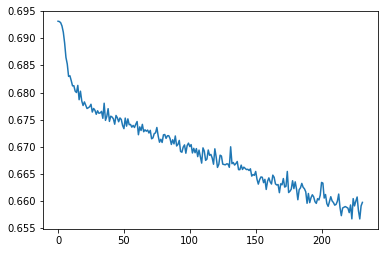

In [51]:
parameters = init()
m=Y_train.shape[0]
costs=[]
grads={}

W1 = parameters["W1"]
W2 = parameters["W2"]
W3 = parameters["W3"]


v,s = init_adam_prm(parameters)

#mini_batches = init_mini_batches(X_train,Y_train,64)
#print(mini_batches[0][0].shape)
#return 0
t=0
for i in range(30001):
    #print(i)
    try:
        shuffle(X_train,Y_train,i+1)
        mini_batches = init_mini_batches(X_train,Y_train,64)
        cost=0
        
        #num=0
        for mini_batch in mini_batches:
            
            (minibatch_X,minibatch_Y) = mini_batch

            n=minibatch_Y.shape[0]

            Z1 =three_dimn_conv(minibatch_X,W1,1,0)
            A1=relu(Z1)
            Z2 =three_dimn_conv(A1,W2,1,0) 
            A2=relu(Z2)
            f_c=np.reshape(A2,(A2.shape[0],A2.shape[1]*A2.shape[2]))
            Z3 = np.dot(f_c,W3.T)
            A3=sigmoid(Z3)
            cost += compute_cost(A3,minibatch_Y)
            #print(cost)
            
            dZ3 = A3 - minibatch_Y
            dW3 = np.dot(dZ3.T,f_c)/n
            dF_c = np.dot(dZ3,W3)
            dA2 = np.reshape(dF_c,(A2.shape[0],A2.shape[1],A2.shape[2]))
            dZ2 = np.multiply(dA2,relu_backward(Z2))
            dW2 = d_three_dimn_conv(A1,dZ2,1,0)/n
            npad = ((0, 0), (W2.shape[1]-1, W2.shape[1]-1), (W2.shape[2]-1, W2.shape[2]-1))
            dA1 = three_dimn_conv(np.pad(dZ2,pad_width=npad,mode="constant"),np.rot90(W2,2),1,0)
            dZ1 = np.multiply(dA1,relu_backward(Z1))
            dW1= d_three_dimn_conv(minibatch_X,dZ1,1,0)/n
            grads["dW1"] = dW1
            grads["dW2"] = dW2
            grads["dW3"] = dW3
            t+=1
            parameters,v,s = adam_optimizer(parameters,grads,v,s,t,learning_rate=0.000065)
            W1 = parameters["W1"]
            W2 = parameters["W2"]

            W3 = parameters["W3"]
#num+=1    

            
          #print(num)

        
        if i %1 == 0:
            costs.append(cost/len(mini_batches))
            
        if i %10 == 0:
            #costs.append(cost/len(mini_batches))
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost/len(mini_batches))))
        
    
    except KeyboardInterrupt:
        plt.plot(np.squeeze(costs))
        plt.show()
        br=True
        break
if(br == False):
    plt.plot(np.squeeze(costs))
    plt.show()


print(W1,W2)

In [52]:
print(W1,W2)

[[[0.00939762 0.07122542 0.02396515]
  [0.09890086 0.17044553 0.11456628]
  [0.08722641 0.15356442 0.10318203]]] [[[0.01500514 0.07276269 0.01948238]
  [0.10680118 0.17072866 0.10845766]
  [0.09517636 0.15408428 0.09678584]]]


print(W1,W2)

In [136]:
a=np.random.randint(8,size=(4,2))
b=np.array(([1,2,3,4,]))
print(a)
print(b)

[[5 6]
 [6 0]
 [1 0]
 [4 7]]
[1 2 3 4]


In [145]:
shuffle(a,b,4)

In [146]:

print(a)
print(b)

[[5 6]
 [4 7]
 [1 0]
 [6 0]]
[1 4 3 2]


In [150]:
print(random.randint(1,100))

99


In [45]:
def pred(X,Y,parameters):
    m=Y.shape[0]
    Z1 =three_dimn_conv(X,W1,1,0)
    A1=relu(Z1)
    Z2 =three_dimn_conv(A1,W2,1,0) 
    A2=relu(Z2)
    f_c=np.reshape(A2,(A2.shape[0],A2.shape[1]*A2.shape[2]))
    Z3 = np.dot(f_c,W3.T)
    A3=sigmoid(Z3)
    print(A3.shape)
    pr = np.where(A3>0.5,1,0)
    
    print("prediction accuracy" + " " + str(np.sum((pr == Y))/m))

In [54]:
pred(X_train,Y_train,parameters)

(8005, 1)
prediction accuracy 0.6122423485321674


In [53]:
pred(X_test,Y_test,parameters)

(2023, 1)
prediction accuracy 0.5585763717251606
